# Imports and load models

In [1]:
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
from flair.data import Sentence
from flair.embeddings import WordEmbeddings
%matplotlib inline

# gpu
device = torch.device("cuda:0")
dtype = torch.float

embedding_model_en = WordEmbeddings('en')
embedding_model_de = WordEmbeddings('de')
d_model = 300 # embedding size of fasttext models

I1212 16:14:21.910832  2576 utils.py:431] loading Word2VecKeyedVectors object from C:\Users\Marc\.flair\embeddings\en-fasttext-news-300d-1M
I1212 16:14:23.733858  2576 utils.py:470] loading vectors from C:\Users\Marc\.flair\embeddings\en-fasttext-news-300d-1M.vectors.npy with mmap=None
I1212 16:14:27.664084  2576 utils.py:503] setting ignored attribute vectors_norm to None
I1212 16:14:27.665082  2576 utils.py:437] loaded C:\Users\Marc\.flair\embeddings\en-fasttext-news-300d-1M
I1212 16:14:27.669072  2576 utils.py:431] loading Word2VecKeyedVectors object from C:\Users\Marc\.flair\embeddings\de-wiki-fasttext-300d-1M
I1212 16:14:29.244755  2576 utils.py:470] loading vectors from C:\Users\Marc\.flair\embeddings\de-wiki-fasttext-300d-1M.vectors.npy with mmap=None
I1212 16:14:33.606050  2576 utils.py:503] setting ignored attribute vectors_norm to None
I1212 16:14:33.608046  2576 utils.py:437] loaded C:\Users\Marc\.flair\embeddings\de-wiki-fasttext-300d-1M


# Create positional encodings

In [2]:
sine_mask = [2*i for i in range(d_model//2)]
cosine_mask = [2*i+1 for i in range(d_model//2)]
i = torch.tensor([i for i in range(d_model//2)]).to(device).to(dtype)

# pre compute positional encodings for 75 tokens
positional_encodings = []
for position in range(75):
    
    sine = torch.sin( position / ( 10000 ** (2*i/d_model) ) )
    cosine = torch.cos( position / ( 10000 ** (2*i/d_model) ) )
    
    position_enc = torch.zeros(d_model).to(device)
    position_enc[sine_mask] = sine
    position_enc[cosine_mask] = cosine

    positional_encodings.append(position_enc)

# return pre computed pos encoding
def positional_encoding(sentence):
    num_tokens = len(sentence)
    return positional_encodings[0:num_tokens]

# Test positional encoding

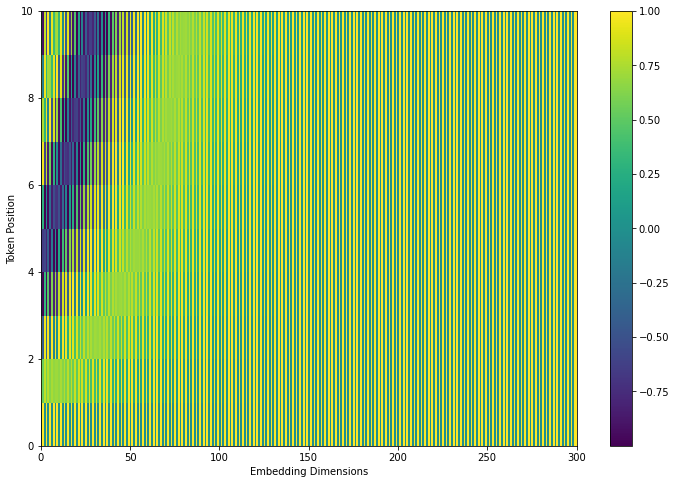

In [3]:
s = Sentence('This is a test a b c r g.',language_code='en')
enc_list = positional_encoding(s)
enc = np.array([token_enc.cpu().numpy() for token_enc in enc_list])

plt.figure(figsize=(12,8))
plt.pcolormesh(enc, cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

# load data and make embeddings + pos encoding 

In [4]:
# data
df = pd.read_csv('data\deu-eng\pairs.txt', delimiter='\t',
                    usecols=[0,1],encoding='utf-8',names=['en','de'])

In [5]:
batch_size = 64
dataset_embedding = []
for line in range(len(df)//batch_size//30):
    
    sentences_en = [ Sentence(sentence,language_code='en') for sentence in df['en'][line*batch_size:line*batch_size+batch_size]]
    sentences_de = [ Sentence(sentence,language_code='de') for sentence in df['de'][line*batch_size:line*batch_size+batch_size]]

    embedding_model_en.embed(sentences_en)
    embedding_model_de.embed(sentences_de)
    
    for sentence_en, sentence_de in zip(sentences_en,sentences_de):
        
        pos_enc_en = positional_encoding(sentence_en)
        pos_enc_de = positional_encoding(sentence_de)
        
        en_embedding = torch.stack([token.embedding + pos_enc_en[i] for i,token in enumerate(sentence_en)])
        de_embedding = torch.stack([token.embedding + pos_enc_de[i] for i,token in enumerate(sentence_de)])
        
        en_tokens = [token.text for token in sentence_en]
        de_tokens = [token.text for token in sentence_de]
        
        dataset_embedding.append([en_embedding, de_embedding, en_tokens, de_tokens])
    
    if line%100 == 0:
        print(f'{line} / {len(df)//batch_size}')

0 / 3506
100 / 3506


In [6]:
filename = 'D:\Transformer\dataset.data'
joblib.dump(dataset_embedding, filename)  

['D:\\Transformer\\dataset.data']

# make vocabulary lists for en and de

In [7]:
en_set = set()
for sentence in df['en']:
    for token in Sentence(sentence):
        en_set.add(token.text)
        
de_set = set()
for sentence in df['de']:
    for token in Sentence(sentence):
        de_set.add(token.text)
        
en_dict = {}
for i, token in enumerate(list(en_set))
    en_dict[i] = token
    en_dict[token] = i
    
de_dict = {}
for i, token in enumerate(list(de_set))
    de_dict[i] = token
    de_dict[token] = i

SyntaxError: invalid syntax (<ipython-input-7-8f15542ff676>, line 12)

In [ ]:
print("Vocabulary en: ",len(en_set))
print("Vocabulary de: ",len(de_set))
filename = 'D:\Transformer\\vocab_en.data'
joblib.dump(en_dict, filename)
filename = 'D:\Transformer\\vocab_de.data'
joblib.dump(de_dict, filename)